<a href="https://colab.research.google.com/github/jhkr1/BigDataAnalysis/blob/main/%ED%9A%8C%EA%B3%84%EC%A7%80%ED%91%9C%EB%A5%BC_%EC%9D%B4%EC%9A%A9%ED%95%9C_%EB%B3%91%EC%9B%90_%EA%B0%9C_%ED%8F%90%EC%97%85_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이콘 회계지표를 이용한 병원 개/폐업 예측 코드 분석

## 1. import

### 1-1) 라이브러리 불러오기

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import math
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.inspection import permutation_importance
from mpl_toolkits.mplot3d import Axes3D

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb

### 1-2) 데이터 불러오기

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

## 2.EDA

### 2-1) 간단한 데이터 확인 및 기본적인 데이터 전처리

In [3]:
print('train_data information')
print(train_data.info())
print()

print('test_data information')
print(test_data.info())

# -> train 데이터의 'employee1'과 'employee2'의 데이터 타입(float)이 test 데이터의 데이터 타입(object)과 다름.

train_data information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 58 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   inst_id             301 non-null    int64  
 1   OC                  301 non-null    object 
 2   sido                301 non-null    object 
 3   sgg                 301 non-null    int64  
 4   openDate            301 non-null    int64  
 5   bedCount            296 non-null    float64
 6   instkind            300 non-null    object 
 7   revenue1            293 non-null    float64
 8   salescost1          293 non-null    float64
 9   sga1                293 non-null    float64
 10  salary1             293 non-null    float64
 11  noi1                293 non-null    float64
 12  noe1                293 non-null    float64
 13  interest1           293 non-null    float64
 14  ctax1               293 non-null    float64
 15  profit1             293 non-null  

In [4]:
# train_data.head()

# test_data.head()

# test_data의 'employee1', 'employee2' 문자열 제거 후, 데이터 타입 변경
test_data['employee1'] = test_data['employee1'].str.replace(',','').astype(float)
test_data['employee2'] = test_data['employee2'].str.replace(',','').astype(float)

In [5]:
# 기본적인 전처리와 EDA를 진행하기 위해 train data와 test data를 합치고, 이를 구분할 수 있도록 index 저장
data = pd.concat([train_data, test_data])
data.index = range(len(data))
train_index = range(len(train_data))
test_index = range(len(train_data), len(data))

# 수치형 컬럼과 범주형 컬럼 구분(inst_id와 Target columns 제외)
numeric_columns = list(data.drop(['inst_id','OC'], axis=1).select_dtypes(include='number').columns)
categorical_columns = list(data.drop(['inst_id','OC'], axis=1).columns.difference(numeric_columns))

# Feature 컬럼과 Target 컬럼 분할(모델 학습시에는 inst_id는 사용 X)
feature_columns = list(data.drop(['inst_id','OC'], axis=1).columns)
target_column = ['OC']

In [6]:
data['OC'].unique() # 타겟변수의 불필요한 공백이 있음 -> 공백 제거 필요
data['OC'] = data['OC'].str.strip()
data['OC'].unique()

array(['open', 'close', nan], dtype=object)

### 2-2) 데이터 확인 및 특이점 확인

In [7]:
# 데이터의 형태 확인
# print('train data의 수: %d, train data의 컬럼 수: %d'%(len(data.loc[train_index, :]), len(data.loc[train_index, :].columns)))
# print('test data의 데이터 수: %d, test data의 컬럼수: %d'%(len(data.loc[test_index, :]), len(data.loc[test_index, :].columns)))

# 위의 코드를 개선한 코드
train_data_info = data.loc[train_index, :]
test_data_info = data.loc[test_index, :]

print(f'train data의 수: {len(train_data_info)}, train data의 컬럼 수: {len(train_data_info.columns)}')
print(f'test data의 수: {len(test_data_info)}, test data의 컬럼 수: {len(test_data_info.columns)}')

train data의 수: 301, train data의 컬럼 수: 58
test data의 수: 127, test data의 컬럼 수: 58


In [8]:
data.columns

# inventoryAsset : 재고자산
# nonCAsset : 비유동자산
# tanAsset : 유형자산
# OnonCAsset : 기타 비유동자산
# receivableL : 장기미수금
# debt : 부채총계
# revenue : 매출액(총 매출액)
# salescost : 매출원가(판매비용)
# sga : 판매비와 관리비
# salary : 급여
# noi : 영업 외 수익
# noe : 영업 외 비용
# interest : 이자 비용
# ctax : 법인세 비용
# profit : 당기 순이익
# liquidAsset : 유동 자산
# quickAsset : 당좌 자산
# receivableS : 미수금(단기)
# liquidLiabilities : 유동 부채
# shortLoan : 단기 차입금 (유동 부채의 종류 중 하나)
# NCLiabilities : 비유동 부채 (유동 부채의 반대)
# longLoan : 장기차입금 (비유동 부채의 종류 중 하나)
# netAsset : 순자산 총계
# surplus : 이익잉여금

Index(['inst_id', 'OC', 'sido', 'sgg', 'openDate', 'bedCount', 'instkind',
       'revenue1', 'salescost1', 'sga1', 'salary1', 'noi1', 'noe1',
       'interest1', 'ctax1', 'profit1', 'liquidAsset1', 'quickAsset1',
       'receivableS1', 'inventoryAsset1', 'nonCAsset1', 'tanAsset1',
       'OnonCAsset1', 'receivableL1', 'debt1', 'liquidLiabilities1',
       'shortLoan1', 'NCLiabilities1', 'longLoan1', 'netAsset1', 'surplus1',
       'revenue2', 'salescost2', 'sga2', 'salary2', 'noi2', 'noe2',
       'interest2', 'ctax2', 'profit2', 'liquidAsset2', 'quickAsset2',
       'receivableS2', 'inventoryAsset2', 'nonCAsset2', 'tanAsset2',
       'OnonCAsset2', 'receivableL2', 'debt2', 'liquidLiabilities2',
       'shortLoan2', 'NCLiabilities2', 'longLoan2', 'netAsset2', 'surplus2',
       'employee1', 'employee2', 'ownerChange'],
      dtype='object')

In [9]:
# 수치형 데이터 컬럼 별 통계값 확인
pd.DataFrame(data.describe())

# -> profit1, netAseet1, surplus1, profit2, netAsset2, suplus2의 min 값이 음수값 존재

,inst_id,sgg,openDate,bedCount,revenue1,salescost1,sga1,salary1,noi1,noe1,...,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2
count,428.000000,428.000000,4.270000e+02,415.000000,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,...,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,410.000000,400.000000
mean,215.154206,85.436916,2.005034e+07,153.474699,1.448543e+10,2.600554e+09,1.125100e+10,6.180720e+09,3.437587e+08,6.188967e+08,...,1.619825e+05,9.268181e+09,4.390742e+09,1.710907e+09,5.076444e+09,3.240094e+09,5.525791e+09,1.178941e+09,160.456098,149.697500
std,124.453370,51.867136,8.854755e+04,121.469400,2.429913e+10,9.986687e+09,1.684542e+10,9.483958e+09,9.418323e+08,1.335157e+09,...,3.193096e+06,1.513045e+10,7.795737e+09,3.673698e+09,9.220942e+09,5.661182e+09,1.051916e+10,4.720339e+09,202.896891,182.906706
min,1.000000,1.000000,1.976041e+07,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.014780e+10,-8.600000e+09,0.000000,0.000000
25%,107.750000,37.750000,2.001025e+07,63.000000,3.238344e+09,0.000000e+00,2.880497e+09,1.629412e+09,9.943713e+06,8.032983e+07,...,0.000000e+00,1.332548e+09,3.006586e+08,0.000000e+00,2.597232e+07,0.000000e+00,9.690131e+08,0.000000e+00,54.000000,54.000000
50%,214.500000,79.500000,2.007111e+07,143.000000,5.801359e+09,2.055491e+08,5.047266e+09,2.810168e+09,4.747870e+07,2.032758e+08,...,0.000000e+00,3.980001e+09,1.454651e+09,1.189736e+08,1.976311e+09,1.426160e+09,2.808020e+09,0.000000e+00,86.000000,83.500000
75%,322.250000,132.000000,2.011120e+07,195.000000,1.422214e+10,9.618685e+08,1.143769e+10,6.783268e+09,2.405069e+08,5.323127e+08,...,0.000000e+00,1.013772e+10,4.828360e+09,1.698335e+09,4.999309e+09,3.676547e+09,5.524990e+09,2.579386e+08,193.000000,185.500000
max,431.000000,178.000000,2.017061e+07,771.000000,1.810000e+11,1.160000e+11,1.270000e+11,8.239561e+10,9.144171e+09,1.149680e+10,...,6.524231e+07,1.310000e+11,6.846878e+10,3.714334e+10,7.855654e+10,3.620288e+10,1.250000e+11,6.852730e+10,1816.000000,1547.000000


In [10]:
# 데이터 특이점 확인
# 순이익이 똑같은 값을 가진다는 것 -> 정말 희박한 확률. -> 따라서 값을 한 번 확인할 필요가 있다.
data.revenue1.value_counts()

,count
revenue1,
0.000000e+00,5
2.179021e+09,2
7.034041e+10,2
1.889868e+09,2
4.131858e+09,2
...,...
2.544681e+09,1
4.960651e+09,1
9.212685e+09,1


In [11]:
# revenue1 컬럼에서 2번 이상 등장한 값들을 리스트로 만든다.
dup_revenue1_lst = train_data.revenue1.value_counts().index[train_data.revenue1.value_counts().values > 1]

# train_data와 같은 컬럼을 가진 빈 데이터프레임 생성
dup_revenue1_df = pd.DataFrame(columns = train_data.columns)

for i in range(1, len(dup_revenue1_lst)):
  rev_df = data[data['revenue1'] == dup_revenue1_lst[i]]
  # 빈 데이터 프레임에 중복인 데이터 계속 추가
  dup_revenue1_df = pd.concat([dup_revenue1_df, rev_df])

dup_revenue1_df

# 위의 반복문 코드를 간결화하면
# dup_revenue1_df = data[data['revenue1'].isin(dup_revenue1_lst)]


# -> 데이터의 특이점 발견. -> 따라서 삭제 혹은 적절한 조치를 취하도록 하는 것이 EDA의 목적

,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,...,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange
261,366,close,gyeonggi,98,20170120.0,0.0,traditional_clinic,7.162790e+09,8.758944e+08,5.387362e+09,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,79.0,70.0,same
262,367,open,gyeonggi,98,20090507.0,4.0,clinic,7.162790e+09,8.758944e+08,5.387362e+09,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,79.0,70.0,same
272,383,open,ulsan,125,20160826.0,176.0,hospital,5.414029e+10,0.000000e+00,4.580684e+10,...,4.448925e+10,1.393222e+10,3.250000e+09,3.055704e+10,2.286030e+10,1.672659e+10,4.707295e+09,436.0,216.0,same
273,384,open,ulsan,125,20140804.0,235.0,general_hospital,5.414029e+10,0.000000e+00,4.580684e+10,...,4.448925e+10,1.393222e+10,3.250000e+09,3.055704e+10,2.286030e+10,1.672659e+10,4.707295e+09,436.0,216.0,same
70,106,open,jeonbuk,26,20030710.0,182.0,nursing_hospital,4.131858e+09,1.436118e+08,3.529097e+09,...,2.658296e+09,2.632717e+09,2.442951e+09,2.557878e+07,0.000000e+00,2.487828e+09,0.000000e+00,85.0,74.0,same
71,107,close,jeonbuk,26,19990805.0,NaN,traditional_hospital,4.131858e+09,1.436118e+08,3.529097e+09,...,2.658296e+09,2.632717e+09,2.442951e+09,2.557878e+07,0.000000e+00,2.487828e+09,0.000000e+00,85.0,74.0,same
213,308,open,seoul,36,20160526.0,0.0,clinic,9.125255e+08,5.824151e+07,1.012169e+09,...,1.035994e+09,3.075474e+08,0.000000e+00,7.284463e+08,7.284463e+08,1.679837e+09,0.000000e+00,16.0,15.0,change
214,309,close,seoul,36,20141226.0,0.0,clinic,9.125255e+08,5.824151e+07,1.012169e+09,...,1.035994e+09,3.075474e+08,0.000000e+00,7.284463e+08,7.284463e+08,1.679837e+09,0.000000e+00,16.0,15.0,change
176,264,open,jeonnam,53,20120126.0,652.0,nursing_hospital,1.683125e+10,2.372298e+09,1.234589e+10,...,1.430577e+10,1.682877e+09,2.521391e+06,1.262290e+10,7.366342e+09,1.606544e+10,0.000000e+00,342.0,278.0,change
177,265,close,jeonnam,53,20051111.0,652.0,nursing_hospital,1.683125e+10,2.372298e+09,1.234589e+10,...,1.430577e+10,1.682877e+09,2.521391e+06,1.262290e+10,7.366342e+09,1.606544e+10,0.000000e+00,342.0,278.0,change


### 2-3) Feature Data 확인

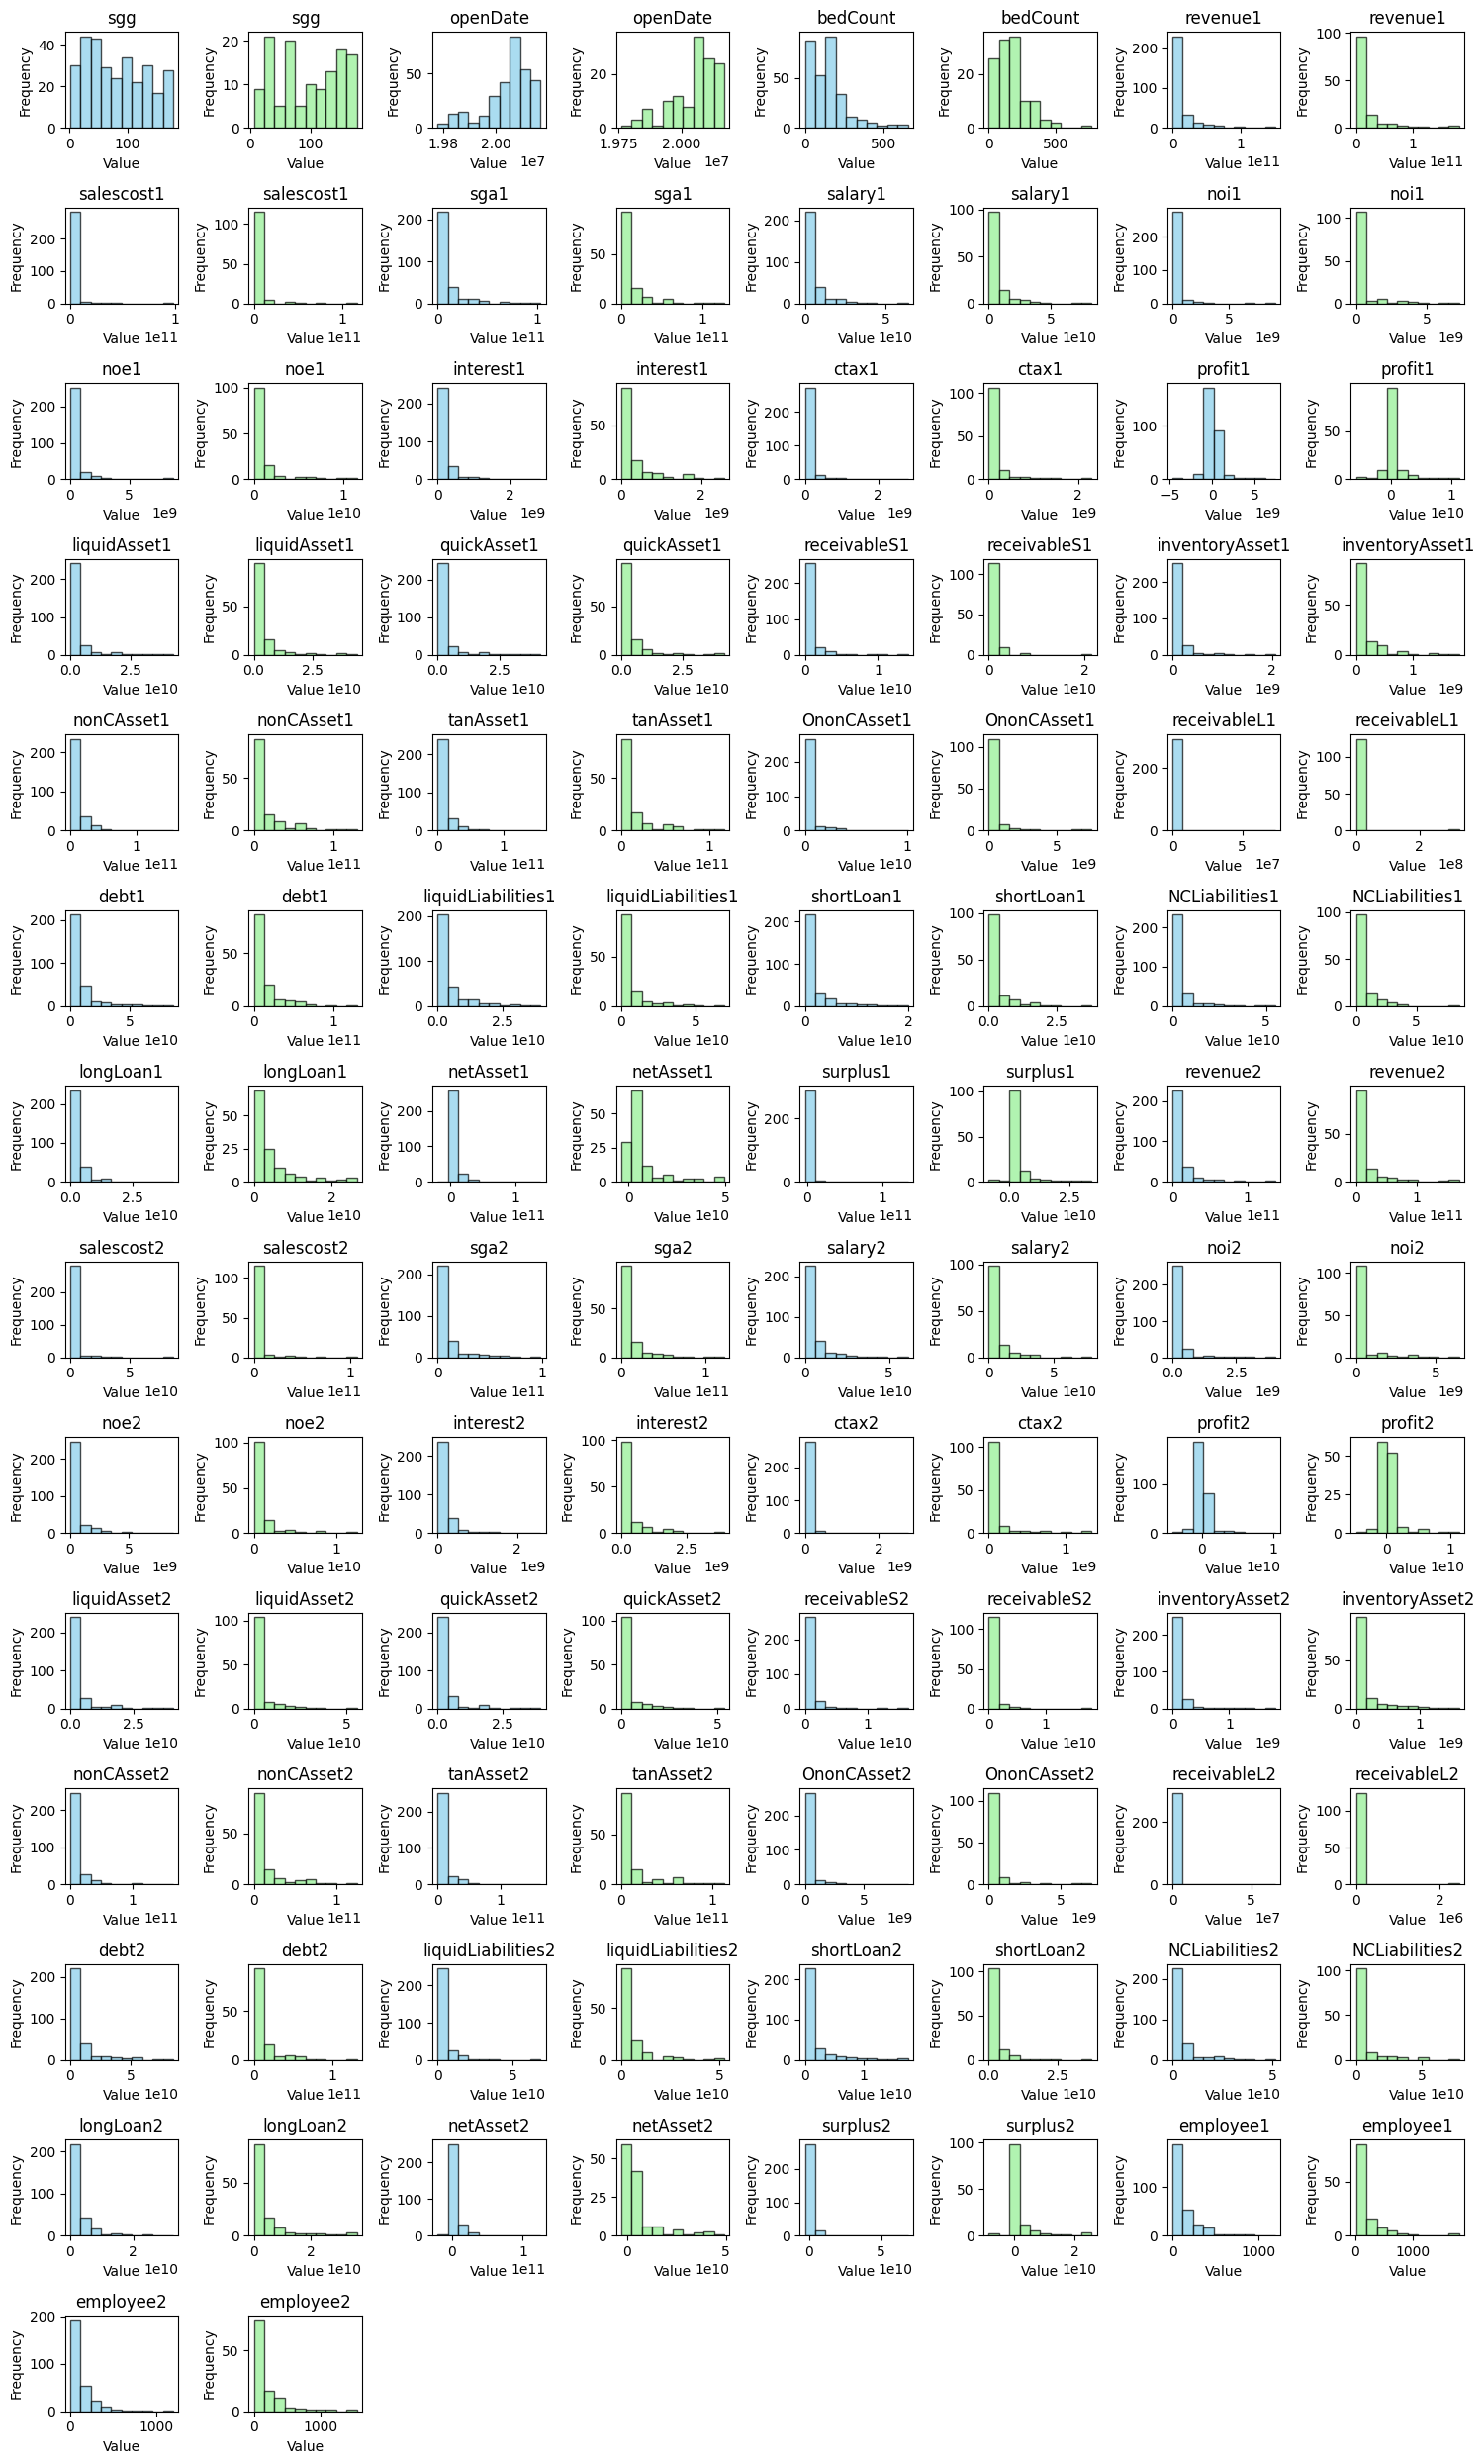

In [12]:
# 숫자형 데이터만 추출 (inst_id 제외)
numeric_train_df = data.loc[train_index, numeric_columns]
numeric_test_df = data.loc[test_index, numeric_columns]

# 숫자형 데이터의 개수와 히스토그램 subplot 생성
num_rows = 14
num_cols = 8

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 25))

# 숫자형 컬럼의 개수 * 2만큼의 범위를 2 간격으로 생성 -> train/test data를 나란히 그려야하므로
for i, col in zip(range(0, len(numeric_train_df)*2, 2), numeric_columns):
  row_idx = i // num_cols
  col_idx = i % num_cols
  axes[row_idx, col_idx].hist(numeric_train_df[col], bins=10, color='skyblue', edgecolor='black', alpha=0.7)
  axes[row_idx, col_idx].set_title(col)
  axes[row_idx, col_idx].set_xlabel('Value')
  axes[row_idx, col_idx].set_ylabel('Frequency')

  axes[row_idx, col_idx+1].hist(numeric_test_df[col], bins=10, color='lightgreen', edgecolor='black', alpha=0.7)
  axes[row_idx, col_idx+1].set_title(col)
  axes[row_idx, col_idx+1].set_xlabel('Value')
  axes[row_idx, col_idx+1].set_ylabel('Frequency')

# 불필요한 빈 그래프 제거
for i in range(len(numeric_train_df.columns)*2, num_rows*num_cols):
  row_idx = i // num_cols
  col_idx = i % num_cols
  fig.delaxes(axes[row_idx, col_idx])

plt.tight_layout()
plt.show()

# 파란색 -> train data, 녹색 -> test data
# 대체로 train data와 test data의 분포가 비슷
# sgg, openDate를 제외한 대부분의 컬럼의 값들이 왼쪽으로 치우쳐져있다. -> 작은 값이 대부분을 차지한다.
# 즉, 규모가 큰 병원 < 규모가 작은 병원의 데이터 수

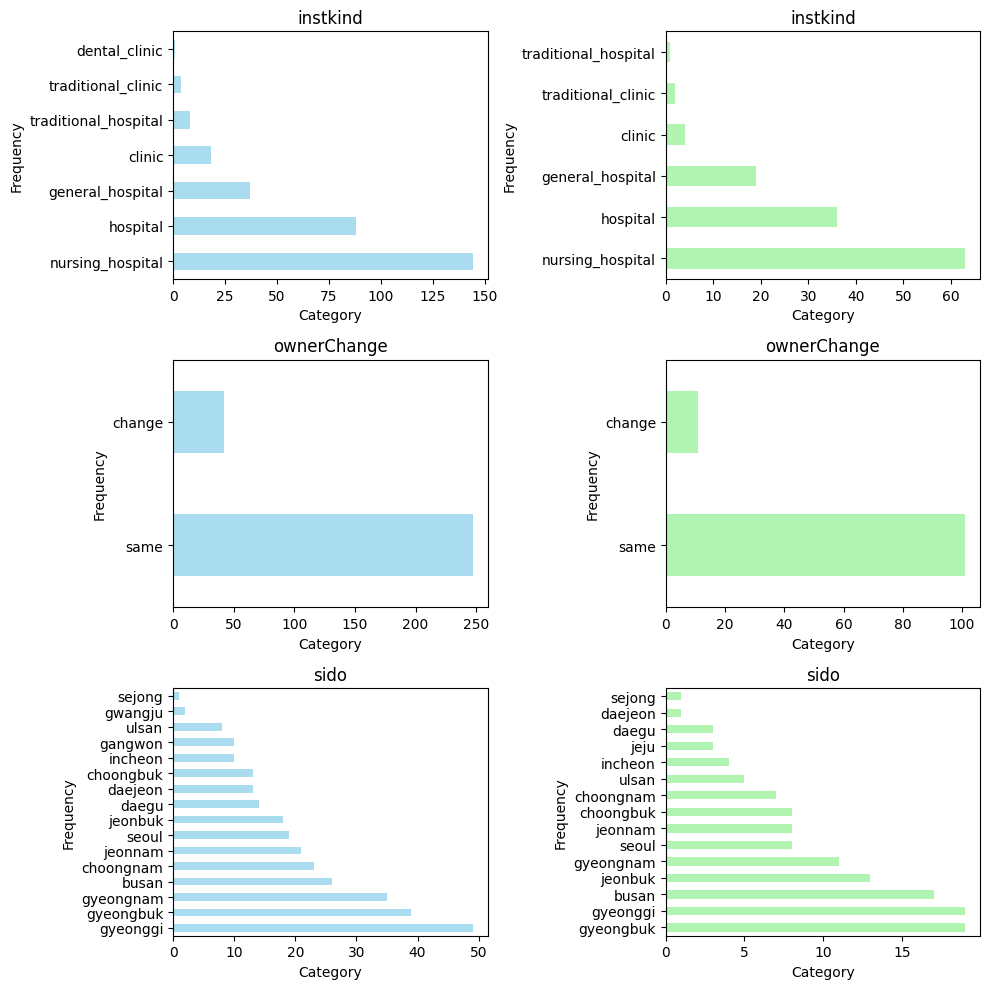

In [13]:
# 시각화 할 카테고리 데이터만 추출(OC 제외)
categorical_train_df = data.loc[train_index, categorical_columns]
categorical_test_df = data.loc[test_index, categorical_columns]

# 카테고리별 빈도수 계산
category_train_counts = {}
category_test_counts = {}
for col in categorical_train_df.columns:
  category_train_counts[col] = categorical_train_df[col].value_counts()
  category_test_counts[col] = categorical_test_df[col].value_counts()

# 카테고리별 빈도수를 시각화하는 막대 그래프 subplot 생성
num_categories = len(categorical_train_df.columns) * 2
num_rows = 3
num_cols = num_categories // num_rows
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

# 각 카테고리별 빈도수에 대해 막대 그래프 그리기
for i, col in zip(range(0, num_categories, 2), categorical_train_df.columns):
    row_idx = i // num_cols
    col_idx = i % num_cols

    category_train_counts[col].plot(kind='barh', ax=axes[row_idx, col_idx], color='skyblue', alpha=0.7)
    axes[row_idx, col_idx].set_title(col)
    axes[row_idx, col_idx].set_xlabel('Category')
    axes[row_idx, col_idx].set_ylabel('Frequency')

    category_test_counts[col].plot(kind='barh', ax=axes[row_idx, col_idx + 1], color='lightgreen', alpha=0.7)
    axes[row_idx, col_idx + 1].set_title(col)
    axes[row_idx, col_idx + 1].set_xlabel('Category')
    axes[row_idx, col_idx + 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# 파란색 -> train data, 녹색 -> test data
# train data, test data가 큰 차이 없이 비슷한 양상


### 2-4) Target Data 확인

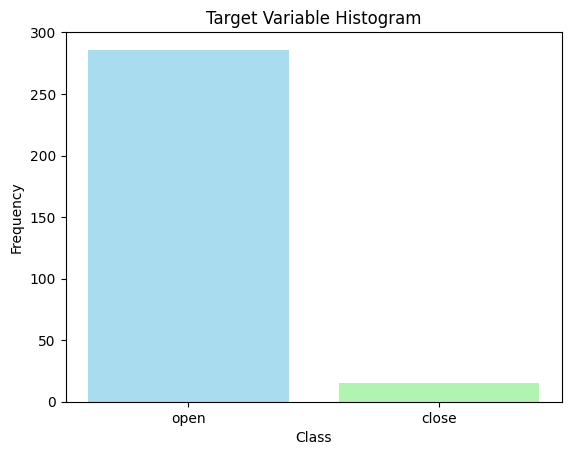

In [14]:
# 빈도수를 시각화하는 히스토그램 그리기
target_name = list(data.loc[train_index, 'OC'].value_counts().index)
target_freq = list(data.loc[train_index, 'OC'].value_counts().values)
plt.bar(target_name, target_freq, color=['skyblue', 'lightgreen'], alpha=0.7)

plt.title('Target Variable Histogram')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.show()

# 학습 데이터의 Target열은 open:286행, close 15행으로 이루어진 불균형 데이터 -> 조치가 필요하다.

### 2-5) 데이터 결측값 확인

In [15]:
# data.loc[train_index, feature_columns] -> train_index 행 즉, train 데이터와 feature_columns로 구성된 데이터프레임 중
# [data.loc[train_index, feature_columns].isnull().any(axis=1)] -> 결측치가 하나라도 있는 데이터를 필터링하겠다는 코드
null_train_df = data.loc[train_index, feature_columns][data.loc[train_index, feature_columns].isnull().any(axis=1)]
null_train_df



,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,salary1,noi1,...,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange
1,gyeongnam,32,19970401.0,410.0,general_hospital,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,801.0,813.0,same
14,ulsan,127,20160531.0,237.0,general_hospital,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,951.0,901.0,same
32,incheon,141,19930708.0,232.0,general_hospital,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,323.0,323.0,same
35,gyeonggi,168,20130206.0,132.0,nursing_hospital,2.681766e+09,1.802009e+08,2.014580e+09,9.366451e+08,59924069.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,51.0,NaN,change
48,seoul,1,19940425.0,28.0,traditional_hospital,8.872427e+09,9.641249e+08,7.638920e+09,4.488958e+09,19153521.0,...,5.958278e+09,5.956278e+09,4.992758e+09,2.000000e+06,0.000000e+00,3.625952e+09,0.000000e+00,NaN,NaN,NaN
55,gyeonggi,120,20130314.0,327.0,nursing_hospital,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,200.0,203.0,same
60,gangwon,128,20031201.0,244.0,nursing_hospital,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,busan,64,20170602.0,128.0,nursing_hospital,5.236406e+08,2.306773e+07,8.355775e+08,5.644636e+08,7534205.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,38.0,NaN,NaN
71,jeonbuk,26,19990805.0,NaN,traditional_hospital,4.131858e+09,1.436118e+08,3.529097e+09,2.198043e+09,56630198.0,...,2.658296e+09,2.632717e+09,2.442951e+09,2.557878e+07,0.000000e+00,2.487828e+09,0.000000e+00,85.0,74.0,same
93,gyeongbuk,114,20070420.0,203.0,hospital,5.423357e+09,0.000000e+00,5.212041e+09,2.958250e+09,23843435.0,...,2.733619e+09,1.406195e+08,0.000000e+00,2.590000e+09,2.590000e+09,3.752184e+09,0.000000e+00,NaN,NaN,NaN


In [16]:
null_test_df = data.loc[test_index, feature_columns][data.loc[test_index, feature_columns].isnull().any(axis=1)]
null_test_df

,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,salary1,noi1,...,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange
303,jeonnam,103,19890427.0,276.0,general_hospital,2.326031e+10,2.542571e+09,2.308749e+10,1.168734e+10,1.601943e+09,...,0.000000e+00,2.777589e+10,2.182278e+10,0.000000e+00,0.000000e+00,0.000000e+00,1.638540e+10,NaN,NaN,NaN
311,gyeonggi,169,20071109.0,NaN,traditional_clinic,7.034041e+10,1.570361e+10,5.177418e+10,3.204005e+10,4.465973e+08,...,6.241929e+10,1.514333e+10,7.749623e+09,4.727596e+10,3.331840e+10,9.818765e+09,8.483183e+09,532.0,409.0,same
314,seoul,36,20080801.0,173.0,hospital,6.637116e+09,0.000000e+00,7.465698e+09,3.715042e+09,2.303995e+08,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,same
316,busan,64,19950330.0,226.0,general_hospital,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,566.0,566.0,same
321,daegu,40,19970228.0,154.0,hospital,1.351696e+10,2.469251e+09,1.072392e+10,6.759008e+09,2.733386e+07,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,150.0,NaN,NaN
323,jeonbuk,34,20060629.0,NaN,hospital,3.207567e+09,2.656878e+07,3.242981e+09,1.628328e+09,3.703870e+05,...,2.481421e+10,8.077364e+09,0.000000e+00,1.673685e+10,1.028108e+10,1.624724e+10,0.000000e+00,NaN,NaN,NaN
341,jeonnam,144,20081210.0,NaN,nursing_hospital,4.647433e+09,2.328483e+08,4.043634e+09,2.588544e+09,1.272573e+07,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,86.0,96.0,same
353,jeonbuk,136,20050321.0,440.0,nursing_hospital,2.179021e+09,3.122066e+08,1.507567e+09,9.073957e+08,3.343641e+07,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN
357,jeonbuk,26,20121218.0,539.0,nursing_hospital,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,250.0,200.0,same
379,gyeongnam,32,19881017.0,NaN,hospital,4.865826e+09,3.286408e+08,4.518516e+09,2.568101e+09,1.229858e+09,...,8.110172e+09,7.790172e+09,4.367571e+09,3.200000e+08,3.200000e+08,5.824119e+09,4.260808e+09,130.0,65.0,change


### 2-6) Train Data와 Test Data의 분포 확인

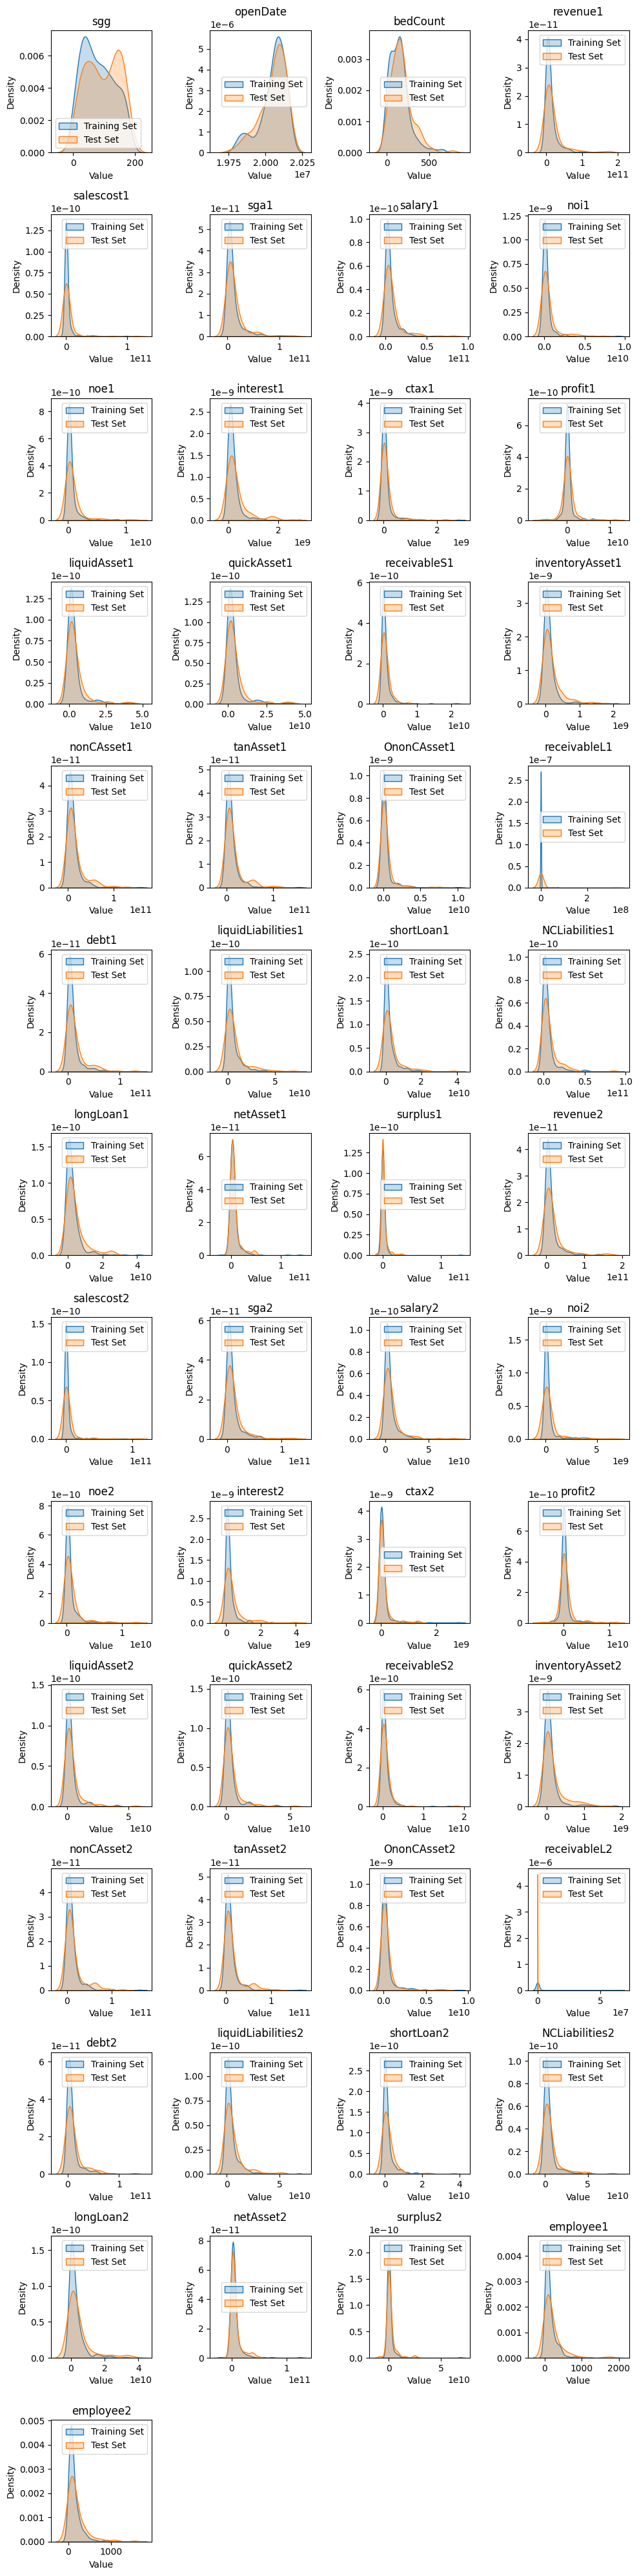

In [17]:
# 숫자형 데이터의 개수와 KDE plot subplot 생성
num_rows = 14
num_cols = 4
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 40), squeeze=False)

# 각 숫자형 데이터 컬럼에 대해 KDE plot 그리기(inst_id, OC 제외)
# KDE(커널 밀도 추정)
for i, col in enumerate(numeric_columns):
  row_idx = i // num_cols
  col_idx = i % num_cols

  sns.kdeplot(numeric_train_df[col], bw_method='silverman', label='Training Set', shade=True,ax=axes[row_idx, col_idx])
  sns.kdeplot(numeric_test_df[col], bw_method='silverman', label='Test Set', shade=True,ax=axes[row_idx, col_idx])
  axes[row_idx, col_idx].set_title(col)
  axes[row_idx, col_idx].set_xlabel('Value')
  axes[row_idx, col_idx].set_ylabel('Density')
  axes[row_idx, col_idx].legend()

# 빈 subplot 숨기기
for i in range(len(numeric_train_df.columns), num_rows*num_cols):
  row_idx = i // num_cols
  col_idx = i % num_cols
  fig.delaxes(axes[row_idx, col_idx])

plt.tight_layout()
plt.show()

# 대부분의 Train Data와 Test Data의 분포가 비슷한 것을 확인할 수 있다. -> 해당 Test Data set이 적절히 추출되었음을 알 수 있다.

### 2-7) Feature 변수(수치형) 간 상관관계 분석

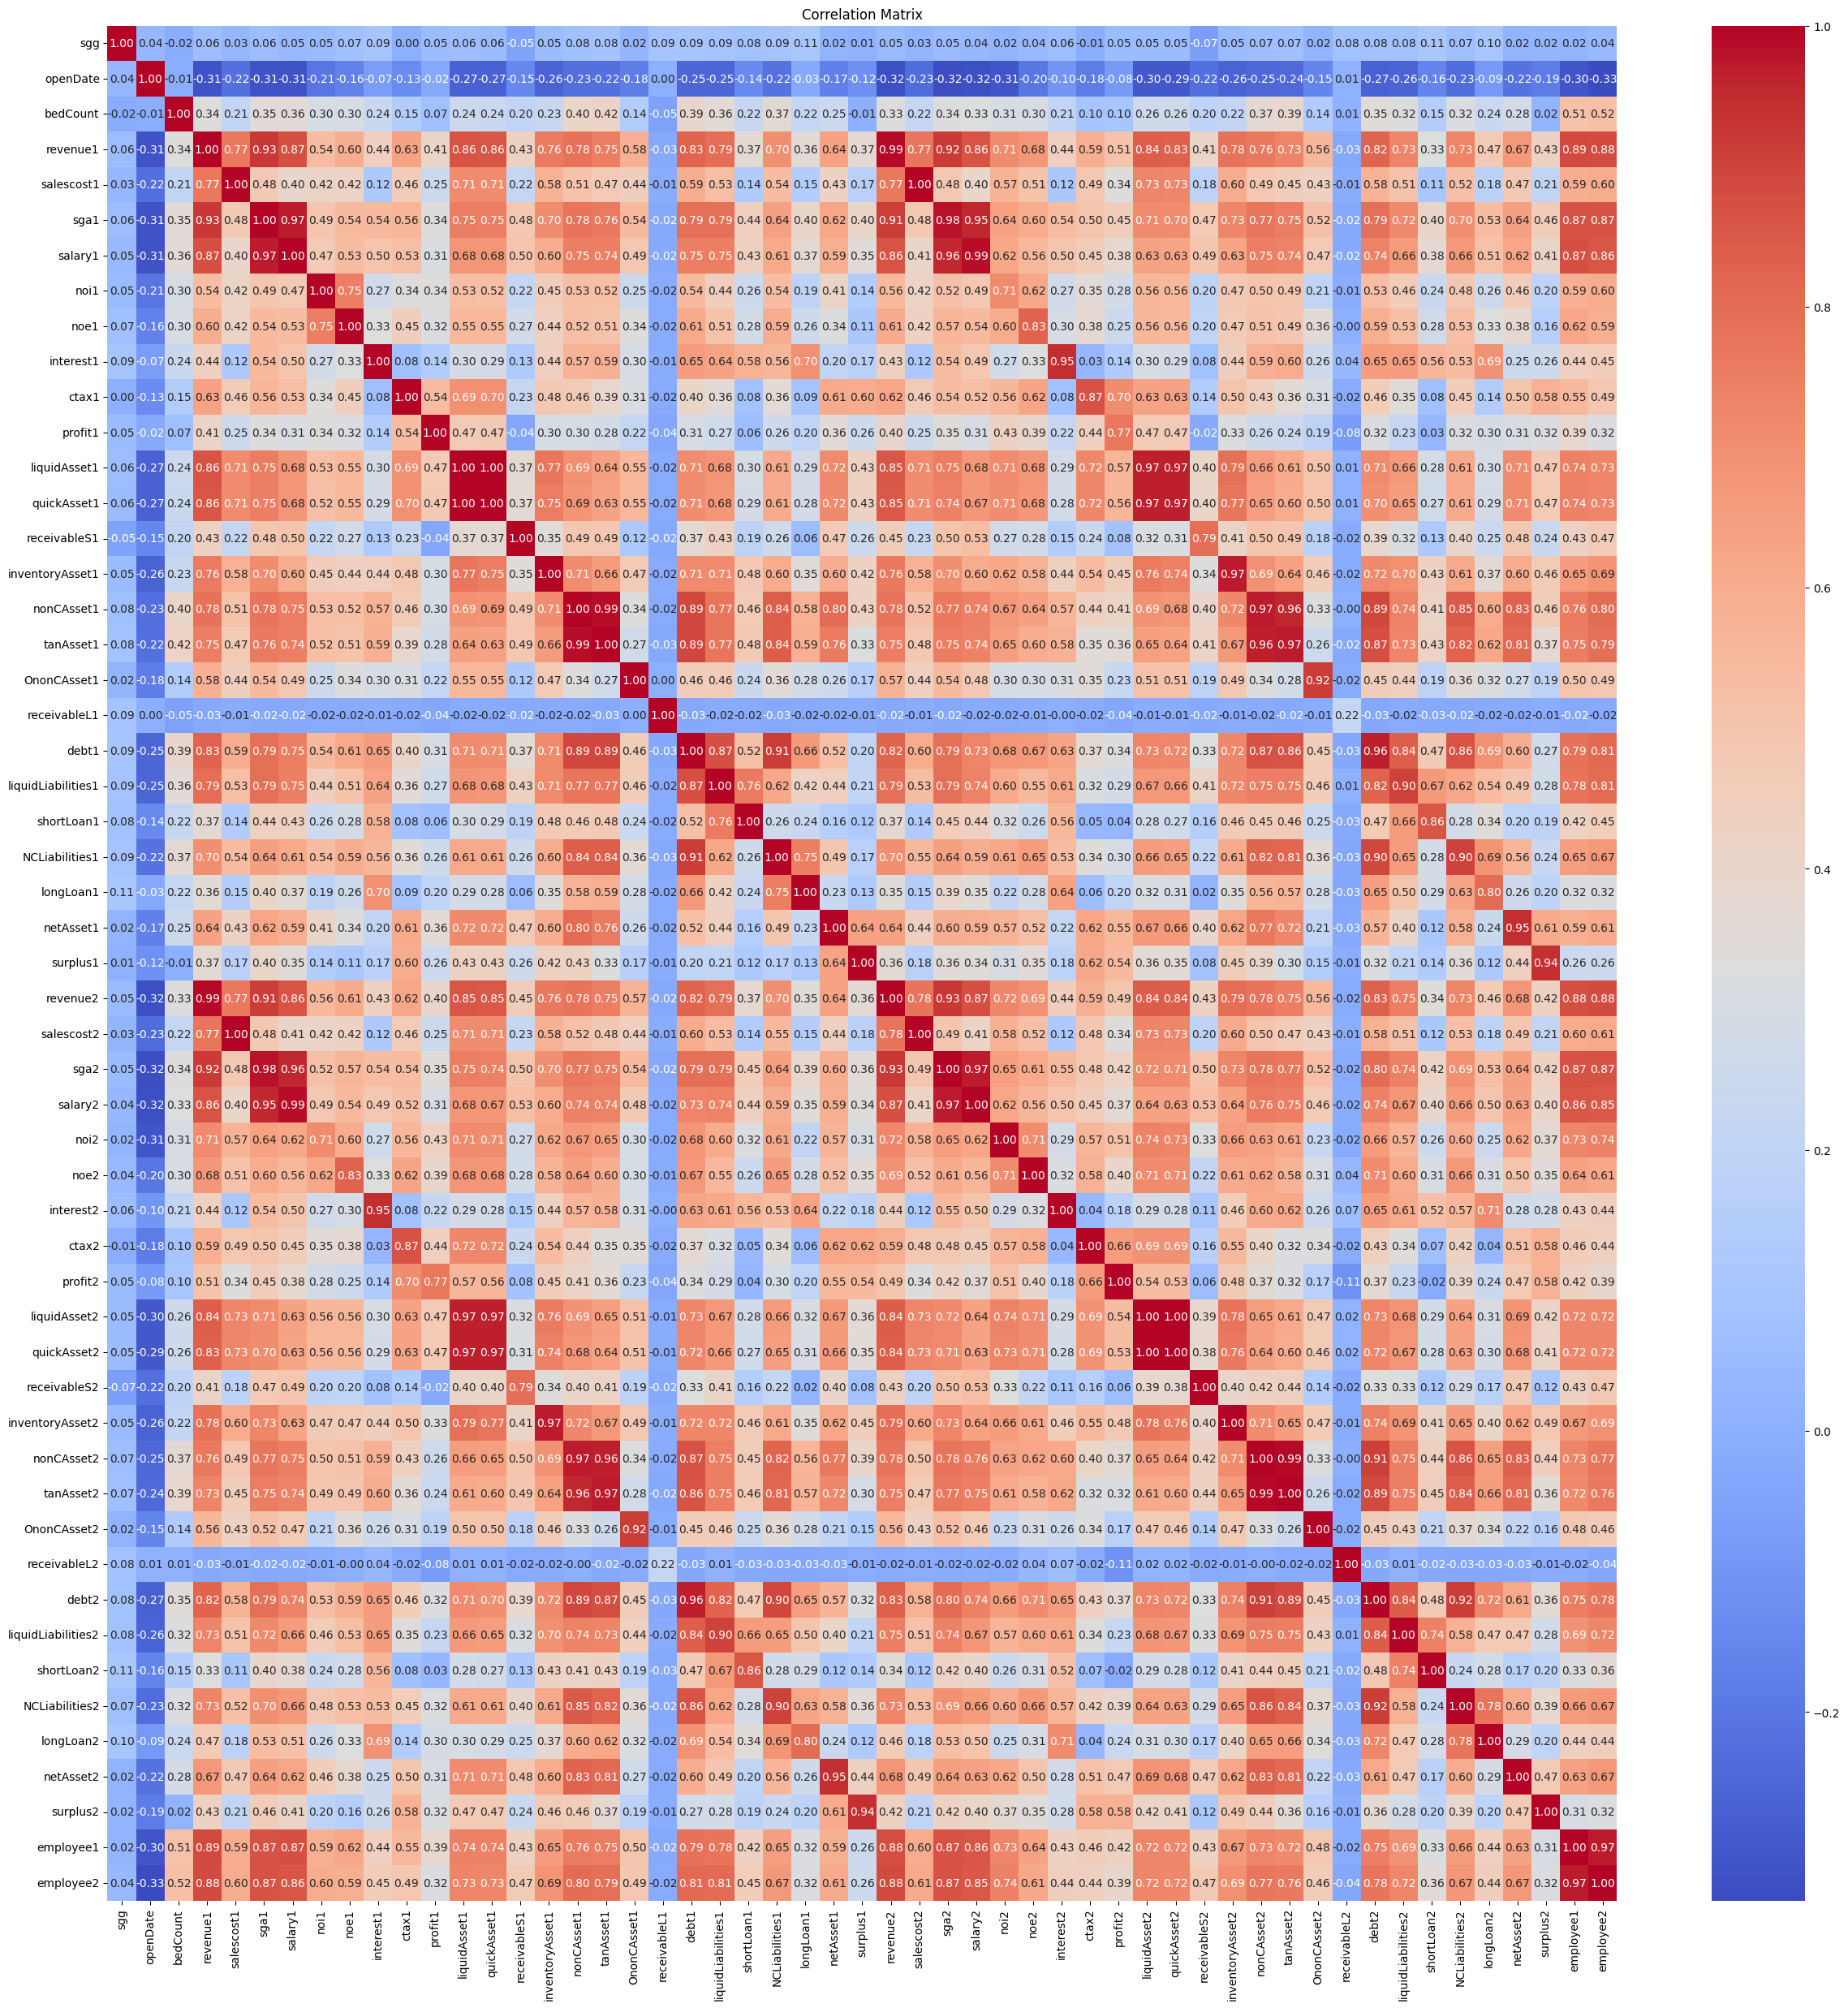

In [18]:
# 상관관계 행렬 계산
correlation_matrix = data.loc[:,numeric_columns].corr()

# 상관관계 행렬 시각화 (heatmap)
plt.figure(figsize=(30, 30))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [19]:
# 0.8 이상의 상관계수만 선택
high_corr_pairs = [(i, j) for i in range(correlation_matrix.shape[0])
                    for j in range(i+1, correlation_matrix.shape[1])
                    if correlation_matrix.iloc[i, j] >= 0.8]
for i,j in high_corr_pairs:
  print(f'상관관계 높은 컬럼: {correlation_matrix.columns[i]} <---> {correlation_matrix.columns[j]} : 상관계수: {correlation_matrix.iloc[i,j]:.2f}')


상관관계 높은 컬럼: revenue1 <---> sga1 : 상관계수: 0.93
상관관계 높은 컬럼: revenue1 <---> salary1 : 상관계수: 0.87
상관관계 높은 컬럼: revenue1 <---> liquidAsset1 : 상관계수: 0.86
상관관계 높은 컬럼: revenue1 <---> quickAsset1 : 상관계수: 0.86
상관관계 높은 컬럼: revenue1 <---> debt1 : 상관계수: 0.83
상관관계 높은 컬럼: revenue1 <---> revenue2 : 상관계수: 0.99
상관관계 높은 컬럼: revenue1 <---> sga2 : 상관계수: 0.92
상관관계 높은 컬럼: revenue1 <---> salary2 : 상관계수: 0.86
상관관계 높은 컬럼: revenue1 <---> liquidAsset2 : 상관계수: 0.84
상관관계 높은 컬럼: revenue1 <---> quickAsset2 : 상관계수: 0.83
상관관계 높은 컬럼: revenue1 <---> debt2 : 상관계수: 0.82
상관관계 높은 컬럼: revenue1 <---> employee1 : 상관계수: 0.89
상관관계 높은 컬럼: revenue1 <---> employee2 : 상관계수: 0.88
상관관계 높은 컬럼: salescost1 <---> salescost2 : 상관계수: 1.00
상관관계 높은 컬럼: sga1 <---> salary1 : 상관계수: 0.97
상관관계 높은 컬럼: sga1 <---> revenue2 : 상관계수: 0.91
상관관계 높은 컬럼: sga1 <---> sga2 : 상관계수: 0.98
상관관계 높은 컬럼: sga1 <---> salary2 : 상관계수: 0.95
상관관계 높은 컬럼: sga1 <---> employee1 : 상관계수: 0.87
상관관계 높은 컬럼: sga1 <---> employee2 : 상관계수: 0.87
상관관계 높은 컬럼: salary1 <---> revenue2 : 상관계수: 0

### 2-7) 병원 개폐업과 개업 기간의 관계

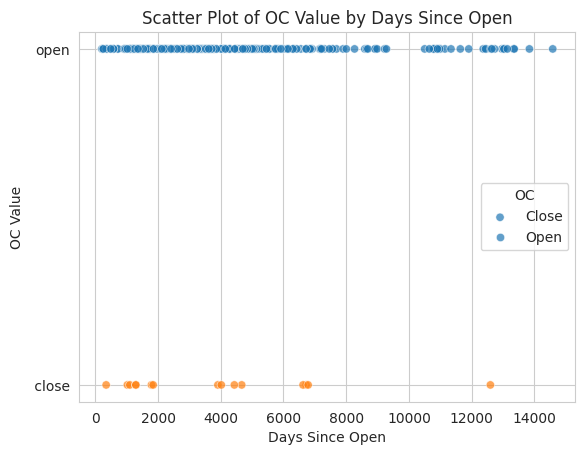

In [20]:
# openDate를 datetime 타입으로 변경하고, 2017년 12월 31일로부터 차이 계산
eda_date_df = pd.DataFrame({'openDate': pd.to_datetime(train_data['openDate'], format='%Y%m%d'),
                            'days_since_open': (pd.Timestamp('2017-12-31') - pd.to_datetime(train_data['openDate'], format='%Y%m%d')).dt.days,
                            'OC': train_data['OC']})
# 필요한 열 선택
data_for_analysis = eda_date_df[['days_since_open', 'OC']]

# scatter plot 그리기
sns.set_style('whitegrid')
sns.scatterplot(data=data_for_analysis, x='days_since_open', y='OC', hue='OC', alpha=0.7)
plt.title('Scatter Plot of OC Value by Days Since Open')
plt.xlabel('Days Since Open')
plt.ylabel('OC Value')
plt.legend(title='OC', labels=['Close', 'Open'])
plt.show()

# x축 -> 개원한 후 2017년 12월 31일까지 며칠을 운영했는지에 대한 데이터
# y축 -> open과 close 두 개의 데이터로 구성
# -> 주로 8000일 이내 폐업
# -> 8000일이 지나도 계속 운영하고 있는 병원도 많음

## 3. Preprocessing

### 3-1) 학습데이터 중, 결측값이 많은 데이터 삭제

In [21]:
# 학습 데이터와 테스트 데이터 분리
train_df = data.loc[train_index, :].copy()
test_df = data.loc[test_index, :].copy()

# 전처리에 사용되지 않는 inst_id와 Target 변수 삭제
train_df = train_df.drop(['inst_id', 'OC'], axis=1)
test_df = test_df.drop(['inst_id', 'OC'], axis=1)

# 대부분 결측값의 개수가 5개 이하였지만, 한 데이터에 48개, 51개의 결측값을 가진 데이터들이 있었음
del_nan_train_df = train_df[train_df.isnull().sum(axis=1) <=5].copy()

print(f'기존 학습 데이터 행 개수:{len(train_df)}')
print(f'결측값이 많은 데이터를 삭제한 후, 남은 데이터의 행 개수:{len(del_nan_train_df)}')

# 학습데이터 index 업데이트
train_index = del_nan_train_df.index




기존 학습 데이터 행 개수:301
결측값이 많은 데이터를 삭제한 후, 남은 데이터의 행 개수:293


### 3-2) 학습 데이터 중, 혼란을 줄 수 있는 데이터 삭제

In [23]:
# EDA 과정에서 확인했던 중복 데이터 중, Feature Data는 같지만 Target Data가 달라 혼란을 줄 수 있는 데이터 삭제
del_dup_train_df = del_nan_train_df.copy()

for rev in dup_revenue1_df[dup_revenue1_df['OC']=='close']['revenue1']:
  del_dup_train_df = del_dup_train_df[del_dup_train_df['revenue1'] != rev]

print('기존 학습 데이터 행 개수: %d'%len(del_nan_train_df))
print('중복 데이터를 삭제한 후, 남은 데이터의 행 개수: %d'%len(del_dup_train_df))

# 학습데이터 index 업데이트
train_index = del_dup_train_df.index


기존 학습 데이터 행 개수: 293
중복 데이터를 삭제한 후, 남은 데이터의 행 개수: 285


### 3-3) 0값들 중, 결측값이라고 볼 수 있는 데이터를 결측값으로 수정

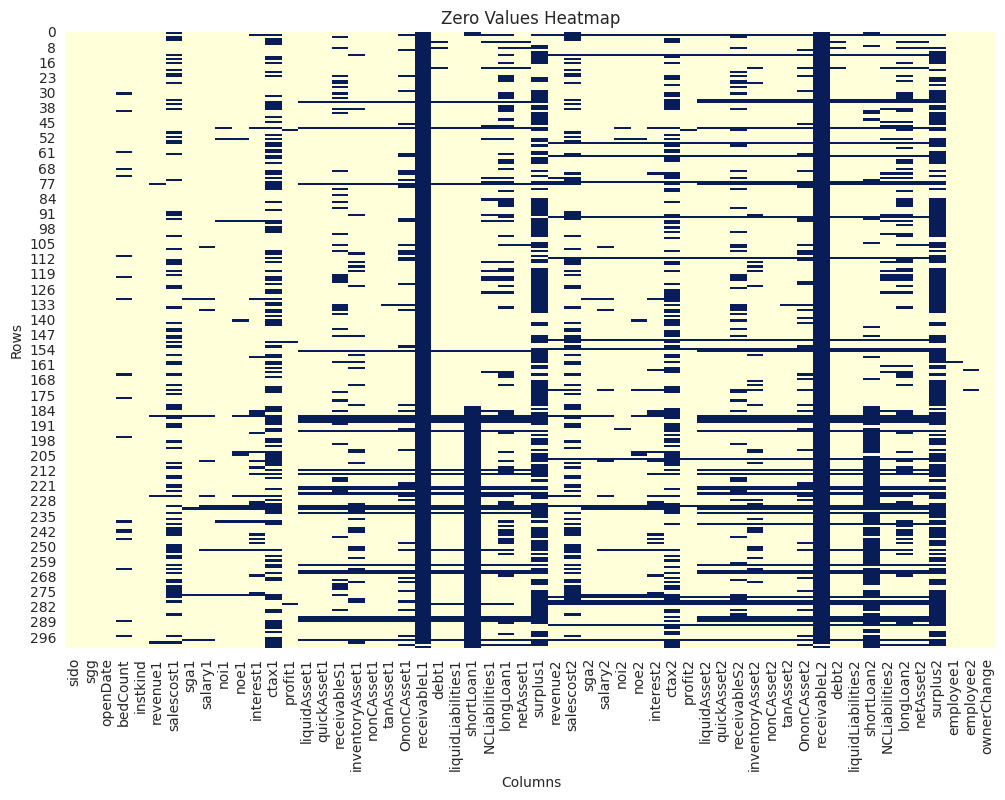

In [26]:
# 0값을 확인
zero_value_rows = pd.DataFrame(del_dup_train_df[del_dup_train_df.eq(0).any(axis=1)])


# 히트맵 작성
plt.figure(figsize=(12, 8))
sns.heatmap(zero_value_rows==0, cmap='YlGnBu', cbar=False)
plt.title('Zero Values Heatmap')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

# -> 0값이 많은 데이터이다. 각각의 변수를 조사하면서 0값을 통계량으로 받아들일 수 있다는 결론
# but 0값이 연속적으로 나타나는행들의 통게값들은 결측치로 판단하는 것이 더 합리적이라고 판단
# 따라서 위의 값들은 imputation 실시

In [27]:
df1 = del_dup_train_df.copy()
# 행에서 0이 얼마나 연속될 때, 0을 결측치 값으로 볼 것인지에 대한 기준값
n_consecutive_zeros = 15
consecutive_zeros_row = []

# 연속된 0의 개수가 15개 이상인 행의 인덱스를 찾는 반복문
for index, row in df1.iterrows():
  consecutive_zeros = 0
  for value in row:
    if value == 0:
      consecutive_zeros += 1
      if consecutive_zeros >= n_consecutive_zeros:
        consecutive_zeros_row.append(index)
        break
    else:
      consecutive_zeros = 0

# 0값이 결측치로 판단되는 행 확인
consecutive_zeros_df = df1.loc[consecutive_zeros_row]
consecutive_zeros_df


,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,salary1,noi1,...,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange
2,gyeonggi,89,20161228.0,468.0,nursing_hospital,1.004522e+09,5.154837e+08,4.472197e+08,2.964023e+08,76156.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,234.0,1.0,same
11,jeonbuk,136,20130605.0,656.0,nursing_hospital,1.481993e+10,0.000000e+00,1.433499e+10,7.603419e+09,272732334.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,297.0,250.0,same
34,jeonnam,38,20080923.0,101.0,nursing_hospital,8.809012e+09,0.000000e+00,8.387238e+09,3.412377e+09,24733405.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.0,96.0,same
35,gyeonggi,168,20130206.0,132.0,nursing_hospital,2.681766e+09,1.802009e+08,2.014580e+09,9.366451e+08,59924069.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51.0,NaN,change
47,daegu,44,20060818.0,166.0,hospital,1.267251e+10,1.319792e+09,1.129875e+10,6.514155e+09,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,132.0,132.0,same
54,gyeonggi,88,20080702.0,214.0,nursing_hospital,1.124419e+10,0.000000e+00,1.120851e+10,5.154798e+09,11631594.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,201.0,same
62,busan,64,20170602.0,128.0,nursing_hospital,5.236406e+08,2.306773e+07,8.355775e+08,5.644636e+08,7534205.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.0,NaN,NaN
76,gyeonggi,98,20010731.0,55.0,hospital,7.159765e+09,8.328257e+08,6.627243e+09,3.395363e+09,61155355.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,79.0,79.0,same
77,incheon,139,20160905.0,162.0,nursing_hospital,0.000000e+00,2.652749e+08,3.842204e+09,2.421379e+09,5907393.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78.0,78.0,same
92,busan,66,20070125.0,159.0,nursing_hospital,4.510755e+09,1.760417e+08,3.833858e+09,2.393068e+09,46397182.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83.0,80.0,same


In [28]:
# test set에서도 동일하게 진행
df2 = test_df.copy()

n_consecutive_zeros = 15
consecutive_zeros_test_rows = []

# 연속된 0의 개수가 15개 이상인 행의 인덱스를 찾는 반복문
for index, row in df2.iterrows():
  consecutive_zeros = 0
  for value in row:
    if value == 0:
      consecutive_zeros += 1
      if consecutive_zeros >= n_consecutive_zeros:
        consecutive_zeros_test_rows.append(index)
        break
    else:
      consecutive_zeros = 0
# 결측치로 판단된 0값을 NaN 값으로 변환
# train set 변환
chg_zero_train_df = del_dup_train_df.copy()
chg_zero_train_df.loc[consecutive_zeros_row, :] = chg_zero_train_df.loc[consecutive_zeros_row, :].replace(0, np.nan)

# test set 변환
test_df.loc[consecutive_zeros_test_rows, :] = test_df.loc[consecutive_zeros_test_rows, :].replace(0, np.nan)

### 3-4) 새로운 Feature 생성

In [30]:
# test 데이터 또한 새로운 변수를 추가해야하므로, train data와 test data를 합쳐 데이터를 처리
chg_zero_df = pd.concat([chg_zero_train_df, test_df])
new_df = pd.DataFrame()

# 범주형 데이터는 그대로 복사
new_df[categorical_columns] = chg_zero_df[categorical_columns].copy()

# 매출액 변화, 평균
new_df['revenue_change'] = chg_zero_df['revenue1'] - chg_zero_df['revenue2']
new_df['revenue_mean'] = (chg_zero_df['revenue1'] + chg_zero_df['revenue2']) / 2

# 매출원가 변화, 평균
new_df['salescost_change'] = chg_zero_df['salescost1'] - chg_zero_df['salescost2']
new_df['salescost_mean'] = (chg_zero_df['salescost1'] + chg_zero_df['salescost2']) / 2

# 판매비와 관리비 변화, 평균
new_df['sga_change'] = chg_zero_df['sga1'] - chg_zero_df['sga2']
new_df['sga_mean'] = (chg_zero_df['sga1'] + chg_zero_df['sga2']) / 2

# 급여 변화, 평균
new_df['salary_change'] = chg_zero_df['salary1'] - chg_zero_df['salary2']
new_df['salary_mean'] = (chg_zero_df['salary1'] + chg_zero_df['salary2']) / 2

# 영업외 수익 변화, 평균
new_df['noi_change'] = chg_zero_df['noi1'] - chg_zero_df['noi2']
new_df['noi_mean'] = (chg_zero_df['noi1'] + chg_zero_df['noi2']) / 2

# 영업외 비용 변화, 평균
new_df['noe_change'] = chg_zero_df['noe1'] - chg_zero_df['noe2']
new_df['noe_mean'] = (chg_zero_df['noe1'] + chg_zero_df['noe2']) / 2

# 이자비용 변화, 평균
new_df['interest_change'] = chg_zero_df['interest1'] - chg_zero_df['interest2']
new_df['interest_mean'] = (chg_zero_df['interest1'] + chg_zero_df['interest2']) / 2

# 법인세 비용 변화, 평균
new_df['ctax_change'] = chg_zero_df['ctax1'] - chg_zero_df['ctax2']
new_df['ctax_mean'] = (chg_zero_df['ctax1'] + chg_zero_df['ctax2']) / 2

# 당기 순이익 변화, 평균
new_df['profit_change'] = chg_zero_df['profit1'] - chg_zero_df['profit2']
new_df['profit_mean'] = (chg_zero_df['profit1'] + chg_zero_df['profit2']) / 2

# 유동자산 변화, 평균
new_df['liquidAsset_change'] = chg_zero_df['liquidAsset1'] - chg_zero_df['liquidAsset2']
new_df['liquidAsset_mean'] = (chg_zero_df['liquidAsset1'] + chg_zero_df['liquidAsset2']) / 2

# 당좌자산 변화, 평균
new_df['quickAsset_change'] = chg_zero_df['quickAsset1'] - chg_zero_df['quickAsset2']
new_df['quickAsset_mean'] = (chg_zero_df['quickAsset1'] + chg_zero_df['quickAsset2']) / 2

# 단기미수금 변화, 평균
new_df['receivableS_change'] = chg_zero_df['receivableS1'] - chg_zero_df['receivableS2']
new_df['receivableS_mean'] = (chg_zero_df['receivableS1'] + chg_zero_df['receivableS2']) / 2

# 재고 자산 변화, 평균
new_df['inventoryAsset_change'] = chg_zero_df['inventoryAsset1'] - chg_zero_df['inventoryAsset2']
new_df['inventoryAsset_mean'] = (chg_zero_df['inventoryAsset1'] + chg_zero_df['inventoryAsset2']) / 2

# 비유동 자산 변화, 평균
new_df['nonCAsset_change'] = chg_zero_df['nonCAsset1'] - chg_zero_df['nonCAsset2']
new_df['nonCAsset_mean'] = (chg_zero_df['nonCAsset1'] + chg_zero_df['nonCAsset2']) / 2

# 유형자산 변화, 평균
new_df['tanAsset_change'] = chg_zero_df['tanAsset1'] - chg_zero_df['tanAsset2']
new_df['tanAsset_mean'] = (chg_zero_df['tanAsset1'] + chg_zero_df['tanAsset2']) / 2

# 기타 비유동 자산 변화, 평균
new_df['OnonCAsset_change'] = chg_zero_df['OnonCAsset1'] - chg_zero_df['OnonCAsset2']
new_df['OnonCAsset_mean'] = (chg_zero_df['OnonCAsset1'] + chg_zero_df['OnonCAsset2']) / 2

# 장기미수금 변화, 평균
new_df['receivableL_change'] = chg_zero_df['receivableL1'] - chg_zero_df['receivableL2']
new_df['receivableL_mean'] = (chg_zero_df['receivableL1'] + chg_zero_df['receivableL2']) / 2

# 부채 총계 변화, 평균
new_df['debt_change'] = chg_zero_df['debt1'] - chg_zero_df['debt2']
new_df['debt_mean'] = (chg_zero_df['debt1'] + chg_zero_df['debt2']) / 2

# 단기차입금 변화, 평균
new_df['shortLoan_change'] = chg_zero_df['shortLoan1'] - chg_zero_df['shortLoan2']
new_df['shortLoan_mean'] = (chg_zero_df['shortLoan1'] + chg_zero_df['shortLoan2']) / 2

# 비유동부채 변화, 평균
new_df['NCLiabilities_change'] = chg_zero_df['NCLiabilities1'] - chg_zero_df['NCLiabilities2']
new_df['NCLiabilities_mean'] = (chg_zero_df['NCLiabilities1'] + chg_zero_df['NCLiabilities2']) / 2

# 장기 차입금 변화, 평균
new_df['longLoan_change'] = chg_zero_df['longLoan1'] - chg_zero_df['longLoan2']
new_df['longLoan_mean'] = (chg_zero_df['longLoan1'] + chg_zero_df['longLoan2']) / 2

# 순자산 총계 변화, 평균
new_df['netAsset_change'] = chg_zero_df['netAsset1'] - chg_zero_df['netAsset2']
new_df['netAsset_mean'] = (chg_zero_df['netAsset1'] + chg_zero_df['netAsset2']) / 2

# 이익잉여금 변화, 평균
new_df['surplus_change'] = chg_zero_df['surplus1'] - chg_zero_df['surplus2']
new_df['surplus_mean'] = (chg_zero_df['surplus1'] + chg_zero_df['surplus2']) / 2

# 고용 직원수 변화, 평균
new_df['employee_change'] = chg_zero_df['employee1'] - chg_zero_df['employee2']
new_df['employee_mean'] = (chg_zero_df['employee1'] + chg_zero_df['employee2']) / 2


# 개업 기간 (2017-12-31 - openDate)
chg_zero_df['openDate'] = pd.to_datetime(chg_zero_df['openDate'], format='%Y%m%d')
new_df['duration'] = pd.to_datetime('2017-12-31') - chg_zero_df['openDate']
new_df['duration'] = new_df['duration'].apply(lambda x: x.days)

# train data, test data
new_train_df = new_df.loc[train_index, :].copy()
new_test_df = new_df.loc[test_index, :].copy()

print('기존 학습 데이터의 열 개수: %d' %len(chg_zero_train_df.columns))
print('새로운 학습 데이터의 열 개수: %d' %len(new_train_df.columns))
print('')
print('기존 시험 데이터의 열 개수: %d' %len(test_df.columns))
print('새로운 시험 데이터의 열 개수: %d' %len(new_test_df.columns))

기존 학습 데이터의 열 개수: 56
새로운 학습 데이터의 열 개수: 52

기존 시험 데이터의 열 개수: 56
새로운 시험 데이터의 열 개수: 52


### 3-5) Feature 제거

In [35]:
new_train_df.columns

Index(['instkind', 'ownerChange', 'sido', 'revenue_change', 'revenue_mean',
       'salescost_change', 'salescost_mean', 'sga_change', 'sga_mean',
       'salary_change', 'salary_mean', 'noi_change', 'noi_mean', 'noe_change',
       'noe_mean', 'interest_change', 'interest_mean', 'ctax_change',
       'ctax_mean', 'profit_change', 'profit_mean', 'liquidAsset_change',
       'liquidAsset_mean', 'quickAsset_change', 'quickAsset_mean',
       'receivableS_change', 'receivableS_mean', 'inventoryAsset_change',
       'inventoryAsset_mean', 'nonCAsset_change', 'nonCAsset_mean',
       'tanAsset_change', 'tanAsset_mean', 'OnonCAsset_change',
       'OnonCAsset_mean', 'receivableL_change', 'receivableL_mean',
       'debt_change', 'debt_mean', 'shortLoan_change', 'shortLoan_mean',
       'NCLiabilities_change', 'NCLiabilities_mean', 'longLoan_change',
       'longLoan_mean', 'netAsset_change', 'netAsset_mean', 'surplus_change',
       'surplus_mean', 'employee_change', 'employee_mean', 'durati

In [36]:
# 학습데이터를 이용하여 상관계수가 높지 않은 컬럼만 추출
correlation_train_matrix = new_train_df.select_dtypes(include=['number']).corr()

correlation = 0.8
exist_columns = list(correlation_train_matrix.columns)

for col1 in correlation_train_matrix.columns:
    if col1 in exist_columns:
        for col2 in exist_columns:
            if col1 != col2:
                if abs(correlation_train_matrix.loc[col1,col2]) >= correlation:
                    exist_columns.remove(col2)

                else: continue
            else: continue
    else: continue

# 범주형 데이터는 상관분석에 사용되지 않았으므로 다시 추가
left_columns = categorical_columns.copy()
left_columns.extend(exist_columns)

# 제거할 Feature을 제거하고, 남은 Feature만 추출하여 새로운 데이터 프레임 생성
del_corr_df = new_df[left_columns].copy()

# train data, test data
del_corr_train_df = new_train_df[left_columns].copy()
del_corr_test_df = new_test_df[left_columns].copy()

print('기존 학습 데이터의 열 개수: %d' %len(new_train_df.columns))
print('상관계수가 높은 열을 삭제한 학습 데이터의 열 개수: %d' %len(del_corr_train_df.columns))
print('')
print('기존 시험 데이터의 열 개수: %d' %len(new_test_df.columns))
print('상관계수가 높은 열을 삭제한 시험 데이터의 열 개수: %d' %len(del_corr_test_df.columns))

기존 학습 데이터의 열 개수: 52
상관계수가 높은 열을 삭제한 학습 데이터의 열 개수: 34

기존 시험 데이터의 열 개수: 52
상관계수가 높은 열을 삭제한 시험 데이터의 열 개수: 34


### 3-6) 결측치 처리